代码对下一棵最有可能被领养的树进行了预测

使用的特征为`template_1`, `likeCount`, `longitude`, `template_68`, `intercept`

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import confusion_matrix

matplotlib.rcParams['axes.unicode_minus'] =False # 显示负号

## 准备数据

In [2]:
# 读data
df = pd.read_json("../../data/all_trees.json")

In [3]:
# 后续还需要保留的变量
data = df.loc[:,[
  # 需要的数据
  'id','owner', 'place', 'longitude', 'latitude', 'likeCount', 'template', 
  # 不考虑纳入模型的
  'height', 'radius', 'subHeight', 'bottomHeight', 
  # 不需要的
  # 'number', 'remark', 'qrcode','available', 'createdAt', 'updatedAt', 'images', 'user', 
  ]]

In [4]:
# 解析json
for i in range(len(df)):
  #template种类编号，habit习性
  template_id = pd.json_normalize(data.loc[i,['template']])
  data.loc[i,'template'] = template_id.loc[0,'id']
  data.loc[i,'habit'] = template_id.loc[0,'habit']
  #owner是否已被认养
  if(data.loc[i,['owner']].isnull().values.any() == False):
    data.loc[i,['owner']] = 1
  else:
    data.loc[i,['owner']] = 0
  #place校区，中北1，闵行0
  if(data.loc[i,['longitude']][0] >= 121.44 ):
    data.loc[i,['place']] = 0
  else: 
    data.loc[i,['place']] = 1

In [5]:
# 异常值处理
data = data.fillna(0)
data = data.replace('', 0)

In [6]:
# 数据
data

,id,owner,place,longitude,latitude,likeCount,template,height,radius,subHeight,bottomHeight,habit
0,3023,1,0,121.453962,31.032579,3,68,0,0,0,0,乔木
1,3021,0,0,121.454747,31.032390,0,223,0,0,0,0,草本
2,3020,0,0,121.451890,31.031580,0,222,2,6,1.5,0,乔木
3,3019,0,0,121.451762,31.029240,0,11,20,60,3.5,0,乔木
4,3018,0,0,121.450062,31.033594,2,30,0,0,0,0,乔木
...,...,...,...,...,...,...,...,...,...,...,...,...
2971,5,1,1,121.406714,31.226994,1,1,17.7,115,3.0,0,乔木
2972,4,1,1,121.406724,31.226958,2,1,21,89.8,6.5,0,乔木
2973,3,1,1,121.406559,31.227018,0,1,18,74,4.7,0,乔木
2974,2,1,1,121.406527,31.226913,0,1,26.3,120,5.3,0,乔木


In [7]:
# 训练所用变量
train_cols = ['owner', 'longitude', 'latitude', 'likeCount', 'template']
train_data = data.loc[:,train_cols]

In [8]:
train_data

,owner,longitude,latitude,likeCount,template
0,1,121.453962,31.032579,3,68
1,0,121.454747,31.032390,0,223
2,0,121.451890,31.031580,0,222
3,0,121.451762,31.029240,0,11
4,0,121.450062,31.033594,2,30
...,...,...,...,...,...
2971,1,121.406714,31.226994,1,1
2972,1,121.406724,31.226958,2,1
2973,1,121.406559,31.227018,0,1
2974,1,121.406527,31.226913,0,1


In [9]:
# 划分X和Y
train_features = train_data.loc[:,['longitude', 'latitude', 'likeCount', 'template']]
train_labels = train_data.loc[:,"owner"]

In [10]:
# 查看n和p
train_features.shape #y = 1的比例：154/2976

(2976, 4)

In [11]:
# 划分 train 和 test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train_features, train_labels, test_size=0.3, random_state=420)
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])
print(" ")
print(Ytrain.value_counts())

 
owner
0    1975
1     108
Name: count, dtype: int64


## 训练

In [12]:
# 使用svc
svc = SVC(kernel='sigmoid', C=1.0, class_weight={1:10}, probability=True)
svc.fit(Xtrain, Ytrain)
print(svc.score(Xtrain, Ytrain))

0.7518002880460873


## 测试

In [13]:
# 结果及效果
result = svc.predict(Xtest)
score = svc.score(Xtest, Ytest)
recall = recall_score(Ytest, result)
auc = roc_auc_score(Ytest, svc.decision_function(Xtest))
print("testing accuracy %f, recall is %f, auc is %f" % (score, recall, auc))

testing accuracy 0.725644, recall is 1.000000, auc is 0.985709


(40,)
(40,)
(40,)


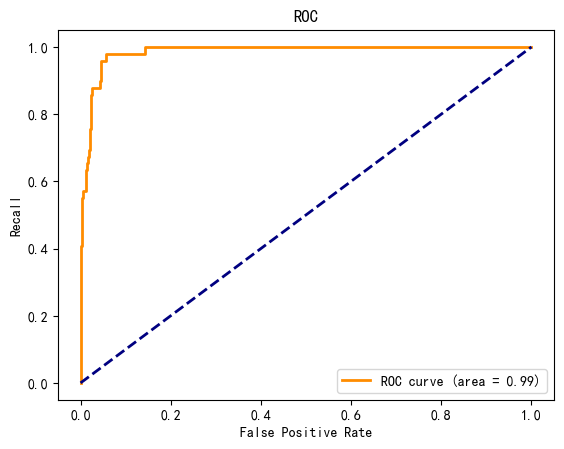

In [14]:
# 绘制roc曲线来评价结果
from sklearn.metrics import roc_curve

FPR, recall, thresholds = roc_curve(y_true=Ytest,  
                                    y_score=svc.decision_function(Xtest),
                                    pos_label=1)
print(FPR.shape) 
print(recall.shape) 
print(thresholds.shape)  # 如果y_score使用的是距离，那么thresholds也是距离；如果y_score使用的是概率，那么thresholds也是概率

plt.figure()
plt.plot(FPR, recall, c='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % auc)  # ROC 曲线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC')  # 设置标题
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()

In [15]:
diff = recall - FPR
maxIdx = diff.tolist().index(max(diff))
print('约登指数是：%f' % thresholds[maxIdx])

约登指数是：0.996836


In [16]:
# 混淆矩阵
print(confusion_matrix(y_true=Ytest, y_pred=svc.predict(Xtest), labels=[1, 0])) 
print(confusion_matrix(y_true=Ytrain, y_pred=svc.predict(Xtrain), labels=[1, 0]))  

[[ 49   0]
 [245 599]]
[[ 106    2]
 [ 515 1460]]


混淆矩阵

真实值/预测值  
----1--0
    
1--49--0

0--245--599

## 代回预测

In [17]:
# 概率结果
predict_all = proba = svc.predict_proba(train_features)

pre_0 = pd.Series(predict_all[:, 0], name='pre_0')
pre_1 = pd.Series(predict_all[:, 1], name='pre_1')

# 01结果
predict_all_01 = proba = svc.predict(train_features)

In [18]:
final_data = train_features
final_data.insert(0,'pre_0',pre_0)
final_data.insert(0,'pre_1',pre_1)
final_data.insert(0,'pred',predict_all_01)
final_data.insert(0,'owner',train_labels)
final_data.insert(0,'id',data.loc[:,"id"])

In [19]:
final_data

,id,owner,pred,pre_1,pre_0,longitude,latitude,likeCount,template
0,3023,1,0,1.119818e-05,0.999989,121.453962,31.032579,3,68
1,3021,0,0,1.000000e-07,1.000000,121.454747,31.032390,0,223
2,3020,0,0,1.000000e-07,1.000000,121.451890,31.031580,0,222
3,3019,0,1,5.401159e-02,0.945988,121.451762,31.029240,0,11
4,3018,0,0,3.072849e-03,0.996927,121.450062,31.033594,2,30
...,...,...,...,...,...,...,...,...,...
2971,5,1,1,2.034763e-01,0.796524,121.406714,31.226994,1,1
2972,4,1,1,2.045339e-01,0.795466,121.406724,31.226958,2,1
2973,3,1,1,2.024203e-01,0.797580,121.406559,31.227018,0,1
2974,2,1,1,2.024202e-01,0.797580,121.406527,31.226913,0,1


In [20]:
outputpath=r'pred_tree_svm.csv'
final_data.to_csv(outputpath, sep=',', index=False, header=True, encoding='utf-8-sig')

In [25]:
selected_columns = ["id", "pred", "pre_0", "pre_1", "owner"]
selected_data = final_data[selected_columns]
dict_list = selected_data.to_dict(orient='records')

output_data = [
    {
        'id': item['id'],
        'owner': item['owner'],
        'pred': item['pred'],
        'pred_0': item['pre_0'],
        'pred_1': item['pre_1']
    } for item in dict_list
]

output_file = 'pred_result_svm.json'
with open(output_file, 'w', encoding='utf-8') as f:
    import json
    json.dump(output_data, f, ensure_ascii=False, indent=4)

### 下一个最有可能被领养的植物是 : id=368

In [24]:
temp =  final_data[data['owner'] == 0]
max_index = temp['pre_1'].idxmax()
max_record = temp.loc[max_index,:]
max_record

id           368.000000
owner          0.000000
pred           1.000000
pre_1          0.206653
pre_0          0.793347
longitude    121.406421
latitude      31.226667
likeCount      4.000000
template       1.000000
Name: 2636, dtype: float64